### **Sessão e leitura dos dados**

In [60]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/dgamorim/development/spark/src/exec/spark-3.5.0-bin-hadoop3"

In [61]:
import findspark
findspark.init()

In [62]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [63]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("data/imdb-reviews-pt-br.csv",
                       escape = '\"',
                       inferSchema= True,
                       header = True)

### **Explorando os dados**

Agora que já lemos os dados, vamos explorá-lo entendendo:

* O **tamanho** dos dados
* Os **campos** e o tipo
* O **conteúdo** em cada campo
* A **proporção** das categorias


In [64]:
# O tamanho dos dados
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:49459 N° de colunas:4


In [65]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [66]:
# Conteudo
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [67]:
# Apresentando alguns comentários ditos como negativo ou positivo.
print("Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)
print("Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)

Negativo


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                          

In [68]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



### **Limpando e processando os dados**
 
Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..
 
 

In [69]:
#Lembrando como estão nossos dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



### **WordCloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`. 

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]
tudo

['"Tokyo Eyes" fala de uma menina japonesa de 17 anos que cai como um homem sendo caçado por seu irmão mais velho que é um policial. Este filme manco é de cerca de 50% de enchimento e 50% de conversas, conversas e mais conversas. Você verá o elenco estelar de menos de três pessoas enquanto eles conversam no ônibus, conversam e jogam videogames, conversam e cortam o cabelo, conversam e andam e andam e conversam, conversam no celular, passam o tempo conversando etc. enquanto você lê legendas esperando que algo aconteça. O fino fio de uma história não é suficiente para sustentar um filme com baixo valor de produção final, um elenco escasso, e sem ação, sem romance, sem sexo ou nudez, sem drama pesado ... apenas incessante yadayadayadaing. C-',
 'Cage interpreta um bêbado e é elogiado pela crítica. Elizabeth Shue Na verdade, tem que fazer um amor com a parte mais desprezível e superestimada de estrume em Hollywood. Eu literalmente vomitei enquanto assistia a esse filme. Claro que tive grip

In [71]:
wordcloud = WordCloud(background_color = 'black',
                      width = 1000,
                      height = 600,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(tudo))

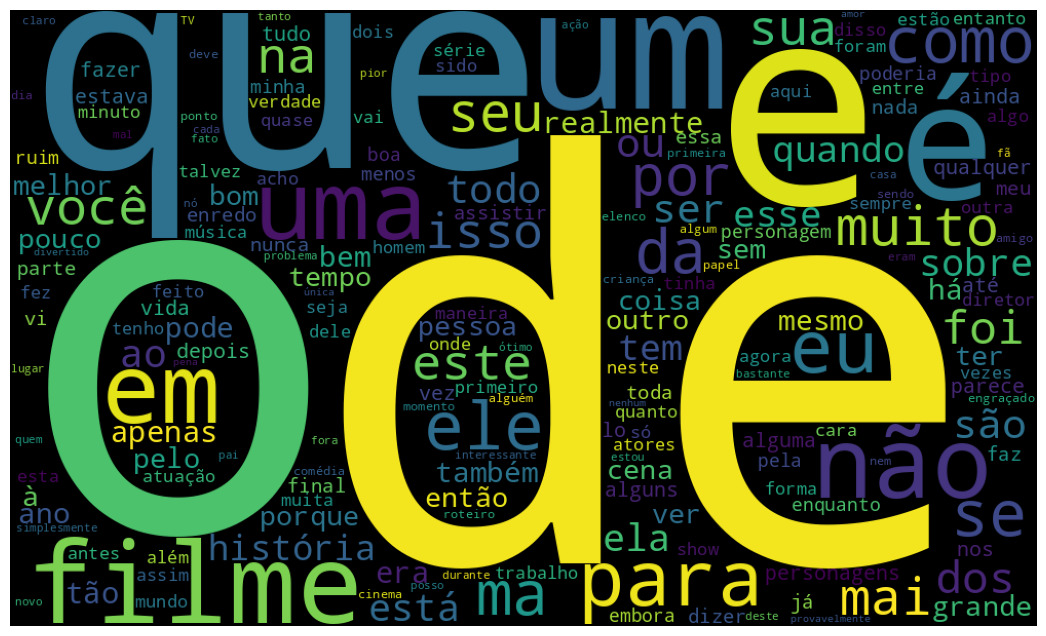

In [72]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Limpeza**: caracteres especiais

In [73]:
# queremos remover esses tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [74]:
# exemplo de dataframe para a limpeza de caracteres especiais
amostra = spark.createDataFrame([
       ("Oi, JP! Blz?",),
       ("$$$\\ |~ Parabéns ~| \\$$$",),
       ("(#amovc #paz&amor ^.^)",),
       ("\"bora *_* \"",),
       ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
       ("{comprar: arroz; feijão e pepino}  //",),
       ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),
       ("ana@gmail.com",)
], ["textos"])
amostra.show()

+--------------------+
|              textos|
+--------------------+
|        Oi, JP! Blz?|
|$$$\ |~ Parabéns ...|
|(#amovc #paz&amor...|
|         "bora *_* "|
|=>->'...``` vc fo...|
|{comprar: arroz; ...|
|!"#$%&'()*+,-./:;...|
|       ana@gmail.com|
+--------------------+



In [75]:
#amostra.show(truncate=False)
import pyspark.sql.functions as f

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [76]:
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~          |[]                             |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [77]:
# Tirando os espaços em brancos no exemplo.
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+-----------------------------+
|textos                                    |texto_regex                    |texto_limpo                  |
+------------------------------------------+-------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                |
|"bora *_* "                               |bora                           |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad            |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |comprar arroz feijão e pepino|
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~    

In [78]:
#1. retirando os caracteres especiais dos dados
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [79]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [80]:
#2. tirar espaços do começo e do final de cada frase:
# poderiamos usar regex, mas vamos usar o trim
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )

In [81]:
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



#### **Tokenização**: divisão em tokens

In [82]:
#3. tokenizando os dados
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [83]:
tokenizado.select("texto_limpo", "tokens").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [84]:
from pyspark.sql.types import IntegerType
# Entendendo em quantos tokens os comentários foram divididos.
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()
# o udf = cria uma função para que seja usado a nivel de linha associado a uma função lambda
# nesse caso ele contou o tamanho da lista, ou seja, a quantidade de tokens que foi gerado para cada registro

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

#### **StopWords**: remoção de ruídos

Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

Vamos começar com um **exemplo pequeno** e depois aplicar em nossos dados.

In [85]:
# Exemplo pequeno
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'), 
        (0, 'Spark MLlib não ajuda muito'), 
        (1, 'O MLlib do Spark ajuda e é fácil')]
        
colNames = ['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [86]:
#Exemplo explorando bibliotecas. (nltk)
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")
# stopwords = são as palvras vazias, ou seja , que somente ela não se da para ter uma ilusão de valor
# exemplo = de, para, do, da, é, lá e etc
# importamos essa bibliteca, pois ela ja possui essas palvras em português

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dgamorim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
#Exemplo explorando bibliotecas. (pyspark)
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")
# essa aqui é a mesma lib que o nltk, só que no framework do spark

In [88]:
# exemplo comparando os diferentes stopwords #A
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenized = tokenizer.transform(df)
## tokenixando as pavras do data frame de exemplo

In [89]:
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords= stop_A)
df = remover.transform(tokenized)
# usando NLTK

In [90]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [91]:
# exemplo comparando os diferentes stopwords #B
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords=stop_B)
df = remover.transform(tokenized)
# usando o stopwords do spark

In [92]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [93]:
# 4. Retirando os stopwords dos depoimentos
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final")
feature_data = remover.transform(tokenizado)


In [94]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [95]:
# Contagem de tokens antes e depois do stopwords.
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()


+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

### **Vetorização**


A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados. 


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos. 

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...



In [96]:
# retomando nosso exemplo
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(df)
df = model.transform(df)

In [97]:
df.select('texto_final', 'CountVec').show(truncate = False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,4,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,2,3],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [98]:
# Quem são as palavras 
model.vocabulary

['spark', 'é', 'ajuda', 'mllib', 'fácil', 'nlp', 'ótimo']

#### **[CountVector](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)**: Frequência das palavras em cada

Para cada observação é gerado vetor com a seguintes estrutura: \\
 `[número de features, [cód. das palavras na ordem do vocabulário],[frequência de cada palavra]]`

In [99]:
# Countvectorizer

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216710,[0,7,8,11...|
|[example, majorit...|(216710,[1,2,3,8,...|
|[first, hate, mor...|(216710,[0,2,4,11...|
|[even, beatles, w...|(216710,[0,1,2,4,...|
|[brass, pictures,...|(216710,[1,3,5,8,...|
+--------------------+--------------------+



23/10/10 09:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


#### **[Hashing TF](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.HashingTF.html)**: alternativa para o Countvector

É gerado a mesma estrutura, entretando aqui limitamos o número de palavras contabilizadas.

In [100]:
# Hashing TF
# Hashing TF é uma opção alternativa para o countvector que limita a quantidade de palavras, no caso, 50 palavras diferentes serão contadas. #numFeatures=1000
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)

In [101]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



#### **TF-IDF**: estabelecendo pesos

O TF-IDF não apenas contabiliza as diferentes palavras, mas também gera pesos para cada um a partir da predomância nos dados.

In [102]:
#TF-IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)

In [103]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### **Codificando**: variável resposta.
Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`



In [104]:
# Lembra que nosso dados estão em texto? Aqui no Pyspark precisamos converter para número e faremos isso com o stringindexer

TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      neg|24765|
|      pos|24694|
+---------+-----+



In [105]:
# Codificando a variável resposta.
# 1. replace
# 2. stringindexer (sentiment -> label)

from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)



In [106]:
# Quem é 0 e quem é 1?
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      neg|  0.0|24765|
|      pos|  1.0|24694|
+---------+-----+-----+



#### **Pipeline**: Transformação dos dados



In [107]:
# Unindo nossas transformações.
from pyspark.ml import Pipeline


tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [108]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [109]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

### **Modelo**

Nosso objetivo é consguir identificar um comentário negativo ou positivo, para isso precisamos criar um modelo em que o computador consiga classificar os depoimentos. Agora que já processamos nossos dados podemos construir um **modelo de classificação**, veja alguma opções:

* Regressão Logística
* Árvore de Decisão
* Florestas Aleatórias
* GX boost
* entre outros...

Para testar nossos dados usaremos todos os procedimentos realizados em Limpeza e processamento dos dados e a vetorização que estabelece pesos para as palavras construidas a partir do TF-IDF.





In [110]:
# Entendendo nossos dados
featureDF = dados_transformados.select(['features', 'label'])

In [111]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [112]:
# tipo lido pelo modelo.
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [113]:
#Pipeline de transformação e ajuste
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

#### **Amostra e Treino**

In [114]:
# separando nossos dados
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [115]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

23/10/10 09:02:05 WARN MemoryStore: Not enough space to cache rdd_387_0 in memory! (computed 8.6 MiB so far)
23/10/10 09:02:05 WARN MemoryStore: Not enough space to cache rdd_387_10 in memory! (computed 8.6 MiB so far)
23/10/10 09:02:05 WARN MemoryStore: Not enough space to cache rdd_387_6 in memory! (computed 8.6 MiB so far)
23/10/10 09:02:05 WARN BlockManager: Persisting block rdd_387_10 to disk instead.
23/10/10 09:02:05 WARN BlockManager: Persisting block rdd_387_6 to disk instead.
23/10/10 09:02:05 WARN BlockManager: Persisting block rdd_387_0 to disk instead.


In [116]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [117]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|  [322.0,858.0]|[0.27288135593220...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

#### **Teste e Métricas**


In [118]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [119]:
#acuracia
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

acuracia = evaluator.evaluate(predictions)


In [120]:
print("Acuracia = %s" % (acuracia))

Acuracia = 0.6689456397881895


#### **Nova frase**

In [121]:
# Este é sem dúvida o pior filme que já vi, odiei a atuação dos atores.
# Adorei o filme, excelente atuação!

In [122]:
nova_base = spark.createDataFrame([
    (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actors."),
    (0, "I loved the movie, excellent acting!"),
], ["id", "texto_limpo"])

In [123]:
nova_class = dt_model.transform(nova_base)

In [124]:
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|[727.0,126.0]|[0.85228604923798...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[183.0,672.0]|[0.21403508771929...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+----------+

